# Animating an agent following a route with ipyleaflet and osmnx

<lead>With `ipyleaflet` you can build beautiful data maps. The `osmnx` package lets you pick a place and build a road network as a graph. Using the graph you can trace paths between locations. Sometimes you want to see how an agent actually follows a path you have defined. For instance to see whether a automatically generated route is actually logical. In this tutorial I will show how you van do this.</lead>

![](example.png)

### Setup necessary packages

The easiest way to start running this notebook is to create an environment from the environment.yml file ([instructions](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file)).


In [1]:
import networkx
from ipywidgets import HTML
import ipyleaflet as ipl
import osmnx as ox
ox.config(use_cache=True, log_console=True)
from time import sleep
import pandas as pd


2022-05-03 10:32:09 Configured OSMnx 1.1.2
2022-05-03 10:32:09 HTTP response caching is on


### Inspect source data
The source data is provided by the [municipality of Amsterdam](https://maps.amsterdam.nl/open_geodata/). For this tutorial I have filtered out the stops for tram line 17 and saved it in a separate file. Each row represents one tram stop for line 17 going from Dijkgraafplein to Kinkerstraat / Bilderdijkstraat.

In [2]:
url = 'tramstops.csv'
source_df = pd.read_csv(url, delimiter=';')

##########
## TEST ##
##########

source_df.head()


,Volgorde,Naam,Modaliteit,Lijn,Lijn_select,RADIUS,Label,WKT_LNG_LAT,WKT_LAT_LNG,LNG,LAT,Unnamed: 11
0,1,Dijkgraafplein,Tram,17 | 27,17|27,5,17 | 27 - Dijkgraafplein,POINT(4.786911 52.355548),POINT(52.355548 4.786911),4.786911,52.355548,NaN
1,2,Baden Powellweg,Tram,17 | 27,17|27,5,17 | 27 - Baden Powellweg,POINT(4.791584 52.356492),POINT(52.356492 4.791584),4.791584,52.356492,NaN
2,3,Hoekenes,Tram,17 | 27,17|27,5,17 | 27 - Hoekenes,POINT(4.799095 52.358004),POINT(52.358004 4.799095),4.799095,52.358004,NaN
3,4,Osdorpplein West,Tram,17 | 27,17|27,5,17 | 27 - Osdorpplein West,POINT(4.803203 52.359418),POINT(52.359418 4.803203),4.803203,52.359418,NaN
4,5,Osdorpplein Oost,Tram,17 | 27,17|27,5,17 | 27 - Osdorpplein Oost,POINT(4.807557 52.359622),POINT(52.359622 4.807557),4.807557,52.359622,NaN


### Get street network as graph
See documentation: https://github.com/gboeing/osmnx-examples

In [3]:
################################################################
## UNCOMMENT WHEN YOU WANT TO LOAD THE GRAPH DATA AND SAVE IT ##
################################################################

# graph = ox.graph_from_place('Amsterdam, the Netherlands')
# ox.io.save_graphml(graph, filepath='amsterdam.graphml', gephi=False, encoding='utf-8')


2022-05-03 10:32:17 Converting node, edge, and graph-level attribute data types
2022-05-03 10:32:19 Loaded graph with 52983 nodes and 139967 edges from "amsterdam.graphml"
2022-05-03 10:32:19 Begin plotting the graph...
2022-05-03 10:32:27 Created edges GeoDataFrame from graph
2022-05-03 10:32:36 Created nodes GeoDataFrame from graph


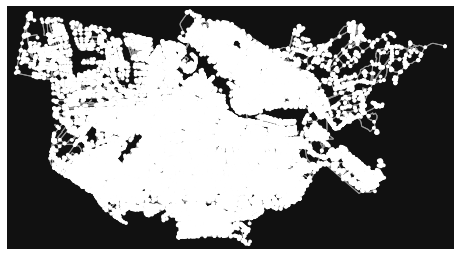

2022-05-03 10:32:42 Finished plotting the graph


(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [4]:
url = 'amsterdam.graphml'
graph = ox.io.load_graphml(url)
ox.plot_graph(graph)


### Data dictionary
Before actually drawing the routes all the necessary data needs to be combined in a logical data structure. As the selected variables have different lengths (single values, lists) a suitable data type is a dictionary. The following functions takes in the source data, a street network and a the starting coordinates (latitude and longitude). It returns a dictionary containing all the data for building the maps and routes.

In [9]:
# Function combining data from source, street network into dictionary
def create_dict(source_df, graph, base_location):
    # Initialize
    selection = ['Lijn', 'Label', 'LAT', 'LNG']
    source_data = source_df[selection]
    location_dic = {}
    start = base_location
    gdf_nodes = ox.graph_to_gdfs(graph)[0]
    
    
    # For every location in the route create an entry with a location_id, a start location and a path list from start to location
    for lx, stop in source_data.iterrows():
        Lijn, Label, LAT, LNG = list(stop)
        location_dic[lx] = {'lijn': Lijn,
                            'label': Label,
                            'start': start,
                            'location': [LAT, LNG]
                            }
        y1, x1 = start
        y2, x2 = location_dic[lx]['location']
        nodes = ox.nearest_nodes(G=graph, X=[x1, x2], Y=[y1, y2])
        print(lx, nodes[0], nodes[1])
        path_nodes = networkx.shortest_path(graph, nodes[0], nodes[1])
        path_coord = gdf_nodes.loc[path_nodes][['x', 'y']]
        path = []
        for point in path_coord.values:
            path.append([point[1], point[0]])
            location_dic[lx]['path'] = path
    
        # Set new start location
        start = location_dic[lx]['location']
            
    return(location_dic)
            

##########
## TEST ##
##########
location_dict = create_dict(
    source_df=source_df, graph=graph, base_location=[52.355548, 4.786911])
location_dict[1]


2022-05-03 10:47:22 Created nodes GeoDataFrame from graph
2022-05-03 10:47:30 Created edges GeoDataFrame from graph
2022-05-03 10:47:30 Created nodes GeoDataFrame from graph
0 8540718163 8540718163
2022-05-03 10:47:31 Created nodes GeoDataFrame from graph
1 8540718163 1741994892
2022-05-03 10:47:31 Created nodes GeoDataFrame from graph
2 1741994892 1992119693
2022-05-03 10:47:31 Created nodes GeoDataFrame from graph
3 1992119693 512526337
2022-05-03 10:47:31 Created nodes GeoDataFrame from graph
4 512526337 1584781466
2022-05-03 10:47:32 Created nodes GeoDataFrame from graph
5 1584781466 3296373954
2022-05-03 10:47:32 Created nodes GeoDataFrame from graph
6 3296373954 2012367419
2022-05-03 10:47:32 Created nodes GeoDataFrame from graph
7 2012367419 2313589833
2022-05-03 10:47:32 Created nodes GeoDataFrame from graph
8 2313589833 2020233498
2022-05-03 10:47:33 Created nodes GeoDataFrame from graph
9 2020233498 6948922043
2022-05-03 10:47:33 Created nodes GeoDataFrame from graph
10 69489

{'lijn': '17 | 27',
 'label': '17 | 27 - Baden Powellweg',
 'start': [52.355548, 4.786911],
 'location': [52.356492, 4.791584],
 'path': [[52.3555836, 4.7869354],
  [52.3555119, 4.7869719],
  [52.3557686, 4.7883544],
  [52.3559376, 4.7891327],
  [52.3561587, 4.7902314],
  [52.3562551, 4.7907514],
  [52.3562766, 4.7908649],
  [52.3562971, 4.790982],
  [52.3563179, 4.7911012],
  [52.3563458, 4.7912612],
  [52.356359, 4.7913242],
  [52.3566417, 4.7926613],
  [52.3567637, 4.7925973],
  [52.3568057, 4.7925732],
  [52.3565624, 4.7913517]]}

### Visualize routes
We will now build a map and add the route and stops to it. First we need to determine the center of the map and all the corners. We will do this by gathering all the latitudes and longitudes in two separate arrays. For each array we can calculate the mean. These mean values will be used as the center point. We can also establish for each array the min and max value which we can use to fit a bounding box for the map.

In [11]:
# Calculate map center and set bounds
latitudes = pd.Series(dtype="float64")
longitudes = pd.Series(dtype="float64")
for point in location_dict.values():
    lat, lon = pd.Series([point["location"][0]]), pd.Series(
        [point["location"][1]])
    latitudes = pd.concat([latitudes, lat])
    longitudes = pd.concat([longitudes, lon])
ce = [latitudes.mean(), longitudes.mean()]
sw = [latitudes.min(), longitudes.min()]
ne = [latitudes.max(), longitudes.max()]
m1 = ipl.Map(center=ce)
m1.fit_bounds([sw, ne])
m1.layout.height = '800px'
m1


Map(center=[52.35913275000001, 4.824016583333333], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [22]:
# Build route layer
trace = []
for point in location_dict.values():
    for path in point["path"]:
        trace.append(path)
lines = ipl.Polyline(
    locations=trace,
    color="tomato",
    fill=False
)
m1.add_layer(lines)

# Build stops locations layer
base = list(location_dict.values())[0]
start = ipl.Circle(
    location=base["start"],
    radius=30,
    color="DimGray",
    fill_color="Skyblue",
    fill=True,
    fill_opacity=1
)
m1.add_layer(start)

for stop in location_dict.values():
    circle = ipl.Circle(
        location=stop["location"],
        radius=20,
        color="DimGray",
        fill_color="SkyBlue",
        fill=True,
        fill_opacity=0.85,
        popup=HTML(str(stop["label"]))
    )
    m1.add_layer(circle)
    
# Add marker
mark = ipl.Marker(location=base["start"])
m1.add_layer(mark)


### Animation
The the actual sequence of visits can be shown using an animated agent that travels through the plotted route.

In [21]:
step = 0.1
for stage in location_dict.values():
    for point in stage["path"]:
        mark.location = point
        sleep(step)
    visited = ipl.Circle(
        location=stage["location"],
        radius=20,
        color="#00b521",
        fill_color="#7fff96",
        fill=True,
        fill_opacity=0.85
    )
    m1.add_layer(visited)